## 1. Setup e Importações
Instale as dependências necessárias e carregue as principais bibliotecas utilizadas ao longo do notebook.

In [6]:
# de dentro de /workspace/QuantumGANs_MedMNIST
!git clone https://github.com/huggingface/diffusers.git; cd diffusers; pip install -e .[training]; pip install -r examples/unconditional_image_generation/requirements.txt


Cloning into 'diffusers'...
remote: Enumerating objects: 103480, done.
remote: Counting objects: 100% (1126/1126), done.
remote: Compressing objects: 100% (610/610), done.
remote: Total 103480 (delta 923), reused 515 (delta 515), pack-reused 102354 (from 2)
Receiving objects: 100% (103480/103480), 77.96 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (76322/76322), done.
Updating files: 100% (2170/2170), done.
Obtaining file:///workspace/QuantumGANs_MedMNIST/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 207.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 331.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 301.1 MB/s eta 0:00:00
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffu

In [1]:
# Instalação de dependências
!pip install -q diffusers accelerate medmnist datasets torchvision
!pip install torchmetrics[image] torch-fidelity


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from accelerate.utils import write_basic_config
write_basic_config()

import os
from pathlib import Path
from medmnist import RetinaMNIST, INFO
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import random
from collections import Counter

# setup seeds
def set_seeds(seed=42):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)

set_seeds(42)

# dataset info
DATA_FLAG = 'retinamnist'
info = INFO[DATA_FLAG]
N_CLASSES = len(info['label'])   # ✅ aqui corrigido
print("Dataset:", DATA_FLAG, "| n_classes:", N_CLASSES, "| task:", info['task'])
print("Labels:", info['label'])

# transform ([-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# carrega splits oficiais
train_dataset = RetinaMNIST(split='train', transform=transform, download=True)
test_dataset  = RetinaMNIST(split='test',  transform=transform, download=True)

# sanity check
def count_labels(ds):
    c = Counter()
    for i in range(len(ds)):
        _, y = ds[i]
        y = int(y) if not torch.is_tensor(y) else int(y.item())
        c[y] += 1
    return c

print("Train label counts:", count_labels(train_dataset))
print("Test  label counts:", count_labels(test_dataset))
x, y = train_dataset[0]
print("Sample shape:", x.shape, "range≈", float(x.min()), float(x.max()), "label:", y)


Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.
Dataset: retinamnist | n_classes: 5 | task: ordinal-regression
Labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}


100%|██████████| 3.29M/3.29M [00:03<00:00, 980kB/s] 
/tmp/ipykernel_10271/3921179164.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(y) if not torch.is_tensor(y) else int(y.item())


Train label counts: Counter({0: 486, 2: 206, 3: 194, 1: 128, 4: 66})
Test  label counts: Counter({0: 174, 2: 92, 3: 68, 1: 46, 4: 20})
Sample shape: torch.Size([3, 28, 28]) range≈ -1.0 0.3176470994949341 label: [0]


## 2. Carregamento e Preparação do Dataset

In [3]:
from pathlib import Path
from medmnist import RetinaMNIST
from PIL import Image

# Diretório base
data_dir = Path('data/retinamnist')
data_dir.mkdir(parents=True, exist_ok=True)

# Cria subpastas class0 ... class4
class_dirs = {}
for ci in range(5):  # RetinaMNIST tem 5 classes
    cdir = data_dir / f'class{ci}'
    cdir.mkdir(parents=True, exist_ok=True)
    class_dirs[ci] = cdir

# Carrega dataset de treino (sem transform, pois vamos salvar PNG)
train_dataset = RetinaMNIST(split='train', download=True)
imgs, labels = train_dataset.imgs, train_dataset.labels.flatten()

# Salva cada imagem na pasta correspondente
for idx, (img, label) in enumerate(zip(imgs, labels)):
    label = int(label)
    Image.fromarray(img.squeeze()).save(class_dirs[label] / f'{idx}.png')

print("Exportação concluída em:", data_dir.resolve())


Exportação concluída em: /workspace/QuantumGANs_MedMNIST/data/retinamnist


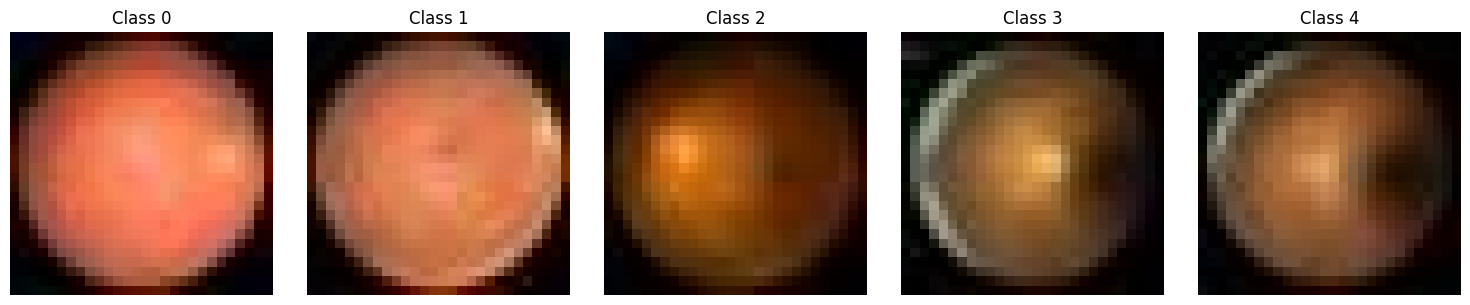

In [25]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

data_dir = Path("data/retinamnist")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ci in range(5):
    # lista de imagens da classe
    img_files = list((data_dir / f"class{ci}").glob("*.png"))
    # escolhe aleatória
    img_path = random.choice(img_files)
    img = Image.open(img_path)

    axes[ci].imshow(img, cmap="gray")
    axes[ci].axis("off")
    axes[ci].set_title(f"Class {ci}")

plt.tight_layout()
plt.show()


## 3. Treinamento do modelo

In [ ]:
!pip install wandb; wandb login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 146.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 172.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

In [7]:
# Classe 0
accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/retinamnist/class0 \
  --resolution 32 \
  --output_dir ddpm_retinamnist_class0 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb

# Classe 1
accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/retinamnist/class1 \
  --resolution 32 \
  --output_dir ddpm_retinamnist_class1 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb

# Classe 2
accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/retinamnist/class2 \
  --resolution 32 \
  --output_dir ddpm_retinamnist_class2 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb

# Classe 3
accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/retinamnist/class3 \
  --resolution 32 \
  --output_dir ddpm_retinamnist_class3 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb

# Classe 4
accelerate launch diffusers/examples/unconditional_image_generation/train_unconditional.py \
  --train_data_dir data/retinamnist/class4 \
  --resolution 32 \
  --output_dir ddpm_retinamnist_class4 \
  --train_batch_size 64 \
  --num_epochs 100 \
  --mixed_precision fp16 \
  --logger wandb


09/09/2025 12:17:49 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

Resolving data files: 100%|████████████████| 147/147 [00:00<00:00, 18445.60it/s]
Generating train split: 147 examples [00:00, 16914.37 examples/s]
09/09/2025 12:17:52 - INFO - __main__ - Dataset size: 147
09/09/2025 12:17:53 - INFO - __main__ - ***** Running training *****
09/09/2025 12:17:53 - INFO - __main__ -   Num examples = 147
09/09/2025 12:17:53 - INFO - __main__ -   Num Epochs = 100
09/09/2025 12:17:53 - INFO - __main__ -   Instantaneous batch size per device = 64
09/09/2025 12:17:53 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 64
09/09/2025 12:17:53 - INFO - __main__ -   Gradient Accumulation steps = 1
09/09/2025 12:17:53 - INFO - __main__ -   Total optimization steps = 300
Epoch 0:   0%|                                            | 0/3 [00:00<?, ?it/s]T

## 4. Avaliação com Métricas
Avaliamos as imagens geradas utilizando as métricas **FID** e **Inception Score**, disponíveis no pacote `torchmetrics`.

### Frechet Inception Distance (FID)


$\mathrm{FID} = \|\mu_r - \mu_g\|^2 + \operatorname{Tr}\left( \Sigma_r + \Sigma_g - 2 \left( \Sigma_r \Sigma_g \right)^{1/2} \right)$


onde:
- $\mu_r$ = média das features reais
- $\mu_g$ = média das features geradas
- $\Sigma_r$ = covariância das features reais
- $\Sigma_g$ = covariância das features geradas

---

### Inception Score (IS)

$ \mathrm{IS} = \exp \left( \mathbb{E}_x \left[ D_{\mathrm{KL}}\left( p(y|x) \;||\; p(y) \right) \right] \right) $

onde:
- $p(y|x)$ = distribuição predita para a imagem gerada
- $p(y)$ = distribuição marginal $p(y) = \int p(y|x) p(x) dx$
- $\mathbb{E}_x$: valor esperado sobre as imagens geradas (média)
- $D_{\mathrm{KL}}$: divergência de Kullback-Leibler


In [13]:
# ==========================================
# Avaliação multi-classe para DDPM (K classes)
# ==========================================
import pandas as pd

@torch.no_grad()
def evaluate_diffusion_pipeline_k(
    pipeline_dir: str,
    device: str,
    dataset,
    label_target: int,           # classe alvo (0..K-1)
    gen_label_name: str,         # nome do gerador (ex.: "class0" ou "No DR")
    real_label_name: str,        # nome da classe real correspondente
    batch_size: int = 64,
    max_batches: int = 10,
    num_inference_steps: int = 50,
    use_fp16: bool = True,
):
    # Métricas
    fid = FrechetInceptionDistance(feature=64).to(device)
    is_metric = InceptionScore().to(device)

    # Carrega pipeline desta classe
    pipe = DDPMPipeline.from_pretrained(
        pipeline_dir,
        torch_dtype=(torch.float16 if use_fp16 else torch.float32)
    ).to(device)
    pipe.set_progress_bar_config(disable=True)

    # Loader dos reais (converte PIL->tensor)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_to_tensor,
        num_workers=0
    )

    batch_count = 0
    for real, labels in loader:
        # real: (B,C,H,W) [0,1], labels: (B,)
        mask = (labels == label_target)
        if mask.sum().item() == 0:
            continue

        real_sel = real[mask]
        b_size = real_sel.size(0)
        if b_size == 0:
            continue

        # Gera b_size imagens sintéticas desta classe
        gen = pipe(batch_size=int(b_size), num_inference_steps=num_inference_steps).images

        # reais -> uint8 3x299x299
        real_uint8 = torch.cat([to_uint8_3ch_299(x) for x in real_sel], dim=0).to(device)

        # fakes -> uint8 3x299x299
        fake_uint8 = torch.cat([to_uint8_3ch_299(any_to_tensor01(x)) for x in gen], dim=0).to(device)

        # atualiza métricas
        fid.update(real_uint8, real=True)
        fid.update(fake_uint8, real=False)
        is_metric.update(fake_uint8)

        batch_count += 1
        if batch_count >= max_batches:
            break

    fid_score = float(fid.compute().item())
    is_mean, is_std = is_metric.compute()
    is_mean = float(is_mean.item() if torch.is_tensor(is_mean) else is_mean)
    is_std  = float(is_std.item() if torch.is_tensor(is_std) else is_std)

    return {
        'Model': 'DDPM',
        'Generator_Label': gen_label_name,
        'Real_Label': real_label_name,
        'FID': fid_score,
        'IS_Mean': is_mean,
        'IS_Std': is_std
    }


def evaluate_diffusion_pipelines_multi(
    ddpm_dir_dict: dict,          # {'class0': 'ddpm_retinamnist_class0', ..., 'class4': ...}
    device: str,
    dataset,
    classes: list = None,         # lista de ints; default: ordena pelas chaves do dict
    label_names: dict = None,     # opcional: {0:'No DR',1:'Mild',...}; senão usa 'class{i}'
    batch_size: int = 64,
    max_batches: int = 10,
    num_inference_steps: int = 50,
    use_fp16: bool = True,
) -> pd.DataFrame:
    # classes a avaliar
    if classes is None:
        classes = sorted(int(k.replace('class', '')) for k in ddpm_dir_dict.keys())

    # nomes “bonitos” para cada classe
    if label_names is None:
        label_names = {c: f'class{c}' for c in classes}

    rows = []
    for c in classes:
        pipe_dir = ddpm_dir_dict[f'class{c}']
        name = label_names.get(c, f'class{c}')
        rows.append(
            evaluate_diffusion_pipeline_k(
                pipeline_dir=pipe_dir,
                device=device,
                dataset=dataset,
                label_target=c,
                gen_label_name=name,        # nome do gerador (classe c)
                real_label_name=name,       # nome da classe real correspondente
                batch_size=batch_size,
                max_batches=max_batches,
                num_inference_steps=num_inference_steps,
                use_fp16=use_fp16
            )
        )
    return pd.DataFrame(rows)


In [16]:
# ==== helpers ausentes: pil_to_tensor01, any_to_tensor01, to_uint8_3ch_299, collate_to_tensor ====
import torch, torch.nn.functional as F
import numpy as np
from PIL import Image

def pil_to_tensor01(img: Image.Image) -> torch.Tensor:
    arr = np.array(img)
    if arr.ndim == 2:
        arr = arr[:, :, None]
    t = torch.from_numpy(arr).float() / 255.0  # [0,1]
    return t.permute(2, 0, 1)                  # C,H,W

def any_to_tensor01(x) -> torch.Tensor:
    if isinstance(x, Image.Image):
        t = pil_to_tensor01(x)
    elif isinstance(x, np.ndarray):
        if x.ndim == 2:
            x = x[:, :, None]
        t = torch.from_numpy(x).float()
        if t.max() > 1.0:
            t = t / 255.0
        t = t.permute(2,0,1) if t.ndim == 3 else t.unsqueeze(0)
    elif torch.is_tensor(x):
        t = x.detach().float()
        if t.ndim == 2:
            t = t.unsqueeze(0)
        # normaliza range caso venha em [-1,1] ou [0,255]
        if t.min() < 0.0:
            t = (t + 1) * 0.5
        elif t.max() > 1.0:
            t = t / 255.0
    else:
        raise TypeError(f"Tipo não suportado: {type(x)}")
    return t.clamp(0,1)

def to_uint8_3ch_299(t01: torch.Tensor) -> torch.Tensor:
    # t01: C,H,W em [0,1]
    if t01.shape[0] == 1:
        t01 = t01.repeat(3,1,1)
    elif t01.shape[0] > 3:
        t01 = t01[:3]
    t = t01.unsqueeze(0)  # 1,C,H,W
    t = F.interpolate(t, size=(299,299), mode='bilinear', align_corners=False)
    return (t.clamp(0,1) * 255.0).round().to(torch.uint8)  # 1,3,299,299

def collate_to_tensor(batch):
    imgs, labels = zip(*batch)
    imgs_t = [any_to_tensor01(x) for x in imgs]  # cada um C,H,W [0,1]
    labels_t = []
    for y in labels:
        if torch.is_tensor(y):
            labels_t.append(y.long().view(-1)[0])
        else:
            labels_t.append(torch.tensor(int(y), dtype=torch.long))
    return torch.stack(imgs_t, dim=0), torch.stack(labels_t, dim=0)
# ==== fim dos helpers ====


In [17]:
import torch
import torch.nn.functional as F
import pandas as pd
from diffusers import DDPMPipeline
from PIL import Image
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Define o device uma vez no notebook
device = "cuda" if torch.cuda.is_available() else "cpu"

ddpm_dir_dict = {
    'class0': 'ddpm_retinamnist_class0',
    'class1': 'ddpm_retinamnist_class1',
    'class2': 'ddpm_retinamnist_class2',
    'class3': 'ddpm_retinamnist_class3',
    'class4': 'ddpm_retinamnist_class4',
}

# (opcional) nomes das classes do RetinaMNIST
# from medmnist import INFO
# label_names = {k:int_name for k,int_name in INFO['retinamnist']['label'].items()}
# O INFO traz keys como strings em algumas versões; garanta inteiros:
# label_names = {int(k): v for k, v in INFO['retinamnist']['label'].items()}

df_results = evaluate_diffusion_pipelines_multi(
    ddpm_dir_dict=ddpm_dir_dict,
    device=device,                 # já definido no seu notebook
    dataset=train_dataset,         # ou test_dataset
    classes=[0,1,2,3,4],
    # label_names=label_names,     # descomente se quiser nomes "No DR", "Mild", ...
    batch_size=64,
    max_batches=10,
    num_inference_steps=50,
    use_fp16=True
)
df_results


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_10271/35062028.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_t.append(torch.tensor(int(y), dtype=torch.long))


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

,Model,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,DDPM,class0,class0,0.559467,1.758704,0.133995
1,DDPM,class1,class1,6.083878,1.729269,0.145039
2,DDPM,class2,class2,7.298479,1.492902,0.164398
3,DDPM,class3,class3,10.761499,1.677768,0.169437
4,DDPM,class4,class4,7.677139,1.430831,0.169460
